In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import re
import numpy as np

import plotly.graph_objs as go
from plotly.offline import iplot

# Emoji to strip emoji
import emoji

In [2]:
#!pip install emoji

# Data Import and Display

In [3]:
# Panda set max col width to none, so that all the text can be display
pd.set_option('display.max_colwidth', None)

df = pd.read_csv("cyberbullying_tweets.csv")
#df.style.set_properties(**{'text-align': 'right'}) # Align all text in columns to left
df.head(10)

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was crapilicious! #mkr",not_cyberbullying
1,@gcarothers eek. i can't stand split keyboards. doesn't work well with MMOs.,not_cyberbullying
2,"@GlennF @Spacekatgal it is rather funny how all of us are so completely different, yet complement each other's skill sets so well.",not_cyberbullying
3,@jukes303 The old oil cliche again. The US pays for every drop of oil they get from the ME on the open market just like every other country.,not_cyberbullying
4,Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc,not_cyberbullying
5,@onebrightlight i've been talking to 2 employees and i heard about a lot of the internal politics re: GG. it's enough to make me stay.,not_cyberbullying
6,"@Jason_Gio meh. :P thanks for the heads up, but not too concerned about another angry dude on twitter.",not_cyberbullying
7,"@RudhoeEnglish This is an ISIS account pretending to be a Kurdish account. Like Islam, it is all lies.",not_cyberbullying
8,"@Raja5aab @Quickieleaks Yes, the test of god is that good or bad or indifferent or weird or whatever, it all proves gods existence.",not_cyberbullying
9,Karma. I hope it bites Kat on the butt. She is just nasty. #mkr,not_cyberbullying


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47693 entries, 0 to 47692
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47693 non-null  object
 1   cyberbullying_type  47693 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


## Text Data Preprocessing For Data Exploration
### In this data exploration section,  I am going to
1. First, do some basic text cleaning using lowercase, regular expression and stopword.  
2. Ultilize the powerful word cloud to visualize most appeared word both in all classes.  
3. Getting highest frequency of unigram and bigram of each class use plot a graph.

In [5]:
# Regular Expression pattern of text cleaning pattern
# This REGEX pattern remove any @tagname from tweet, remove #hashtag !@#$%^&*: etc., remove website name like https:///www.fb.com
# But will remain all the A-Z a-z 0-9 character
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# pip install wordcloud
# import word cloud to produce wordcloud on cleaned twitter text for data exploration
from wordcloud import STOPWORDS
STOPWORDS.update(['rt', 'mkr', 'didn', 'bc', 'n', 'm', 'im', 'll', 'y', 've', 'u', 'ur', 'don', 't', 's'])

# Function To preprocess the twitter text

# Lowercase all text
def lower(text):
    return text.lower()

# To clean the tweet with REGEX above
def clean_tweet_re(text):
    return re.sub(TEXT_CLEANING_RE, ' ', text)

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])


In [6]:
# Create a copy of df for visualization
df_visual = df.copy()

df_visual['tweet_text'] = df_visual['tweet_text'].apply(lower)
df_visual['tweet_text'] = df_visual['tweet_text'].apply(clean_tweet_re)
df_visual['tweet_text'] = df_visual['tweet_text'].apply(remove_stopwords)


# Color Class for python printing, Making print more easy to read
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# Comparing Ori Tweet Text vs cleaned Tweet Text, Original black bold color vs Clean green bold color
for i in range(0, 10):
    original_text = df['tweet_text'].head(10)[i]
    cleaned_text = df_visual['tweet_text'].head(10)[i]
    comparision = f'{color.BOLD} {i}) {original_text} ==>> {color.GREEN} {color.BOLD} {cleaned_text} {color.END}\n'
    print(comparision)

 0) In other words #katandandre, your food was crapilicious! #mkr ==>>   words katandandre food crapilicious 

 1) @gcarothers eek. i can't stand split keyboards. doesn't work well with MMOs. ==>>   eek stand split keyboards doesn work well mmos 

 2) @GlennF @Spacekatgal it is rather funny how all of us are so completely different, yet complement each other's skill sets so well. ==>>   spacekatgal rather funny us completely different yet complement skill sets well 

 3) @jukes303 The old oil cliche again. The US pays for every drop of oil they get from the ME on the open market just like every other country. ==>>   old oil cliche us pays every drop oil open market every country 

 4) Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc ==>>   aussietv white theblock imacelebrityau today sunrise studio10 neighbours wonderlandten etc 

 5) @onebrightlight i've been talking to 2 employees and i heard about a lot of the intern

In [7]:
# Create this function to get the highest frequency of unigram and bigrams

def get_highest_gram(corpus,ngram_range,n=None):
    vec = CountVectorizer(ngram_range=ngram_range,stop_words = STOPWORDS).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# Data Exploration
In this data exploration section, I am going to explore the most used word with wordcloud and bar plot table for each Class (Not Bullying, Gender, Etc)

## Not Bullying Class Word Exploration

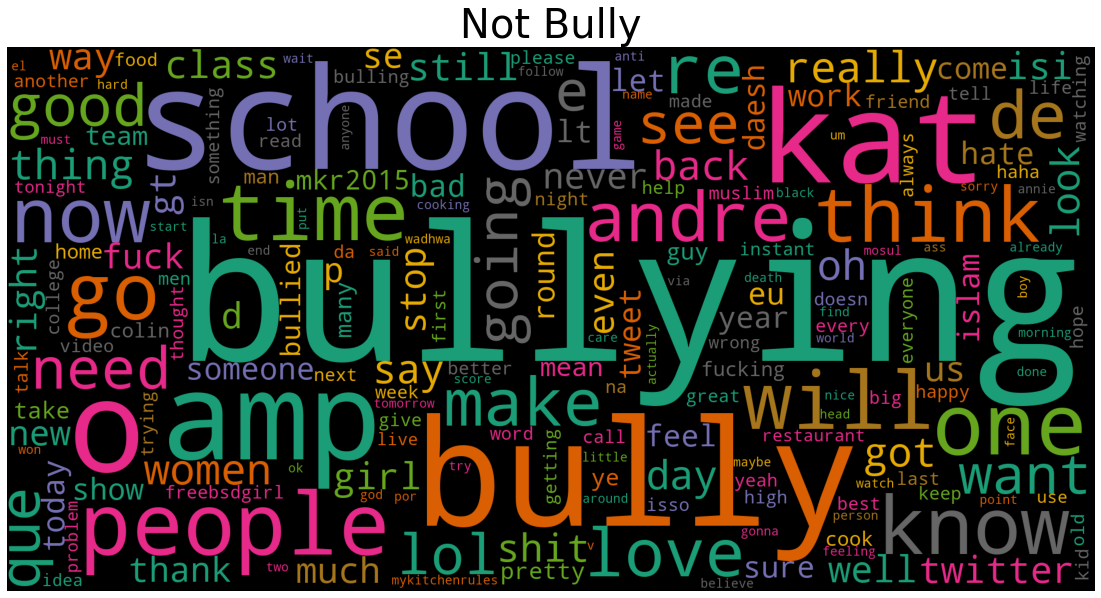

In [8]:
# Import word cloud to visualize highest count word with cloud display effect
from wordcloud import WordCloud

plt.figure(figsize=(20, 10)) #Setting figure size to better width
subset_notbully = df_visual[df_visual['cyberbullying_type'] == 'not_cyberbullying']
text_notbully = subset_notbully.tweet_text.values
cloud_notbully = WordCloud(background_color='black',colormap="Dark2",collocations=False,width=2000,height=1000).generate(" ".join(text_notbully))

plt.axis('off')
plt.title("Not Bully", fontsize=40)
plt.imshow(cloud_notbully)

In [9]:
# Pandas Series object do not have a iplot function
# This code is to use cufflinks to link plotly to pandas and add iplot used at below

import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [10]:
# Get the unigrams, single word that appear most 
unigrams_notbully = get_highest_gram(text_notbully,(1,1),10)

# Get the bigrams, two word that appear most
bigrams_notbully = get_highest_gram(text_notbully,(2,2),10)

notbully_1 = pd.DataFrame(unigrams_notbully, columns = ['Text' , 'count'])
notbully_1.groupby('Text').sum()['count'].sort_values(ascending=True).iplot(kind='bar', yTitle='Count', linecolor='black',color='black', title='Top 10 Unigrams',orientation='h')

notbully_2 = pd.DataFrame(bigrams_notbully, columns = ['Text' , 'count'])
notbully_2.groupby('Text').sum()['count'].sort_values(ascending=True).iplot(kind='bar', yTitle='Count', linecolor='black',color='black', title='Top 10 Bigrams',orientation='h')

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'let', 'mustn', 're', 'shan', 'shouldn', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.



## Gender Class Word Exploration

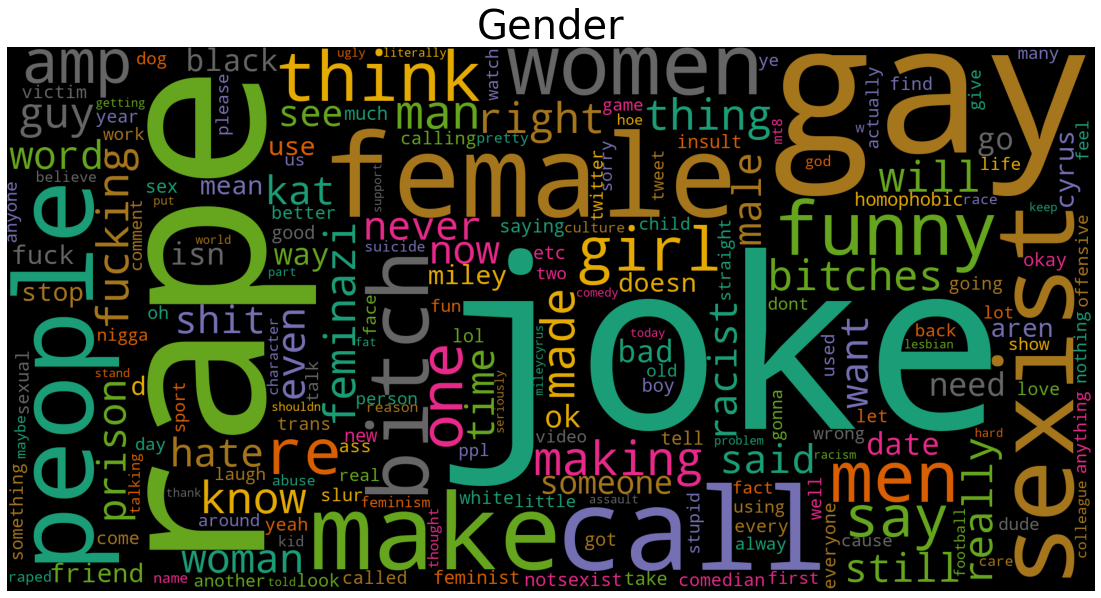

In [11]:
plt.figure(figsize=(20,10)) 
subset1 = df_visual[df_visual['cyberbullying_type'] == 'gender']
text_gender = subset1.tweet_text.values
cloud1=WordCloud(background_color='black',colormap="Dark2",collocations=False,width=2000,height=1000).generate(" ".join(text_gender))

plt.axis('off')
plt.title("Gender",fontsize=40)
plt.imshow(cloud1)

In [12]:
# Get the unigrams, single word that appear most 
unigrams_gender = get_highest_gram(text_gender,(1,1),10)

# Get the bigrams, two word that appear most
bigrams_gender = get_highest_gram(text_gender,(2,2),10)

gender_1 = pd.DataFrame(unigrams_gender, columns = ['Text' , 'count'])
gender_1.groupby('Text').sum()['count'].sort_values(ascending=True).iplot(kind='bar', yTitle='Count', linecolor='black',color='black', title='Top 10 Unigrams',orientation='h')

gender_2 = pd.DataFrame(bigrams_gender, columns = ['Text' , 'count'])
gender_2.groupby('Text').sum()['count'].sort_values(ascending=True).iplot(kind='bar', yTitle='Count', linecolor='black',color='black', title='Top 10 Bigrams',orientation='h')

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'let', 'mustn', 're', 'shan', 'shouldn', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.



## Age Bully Class Word Exploration

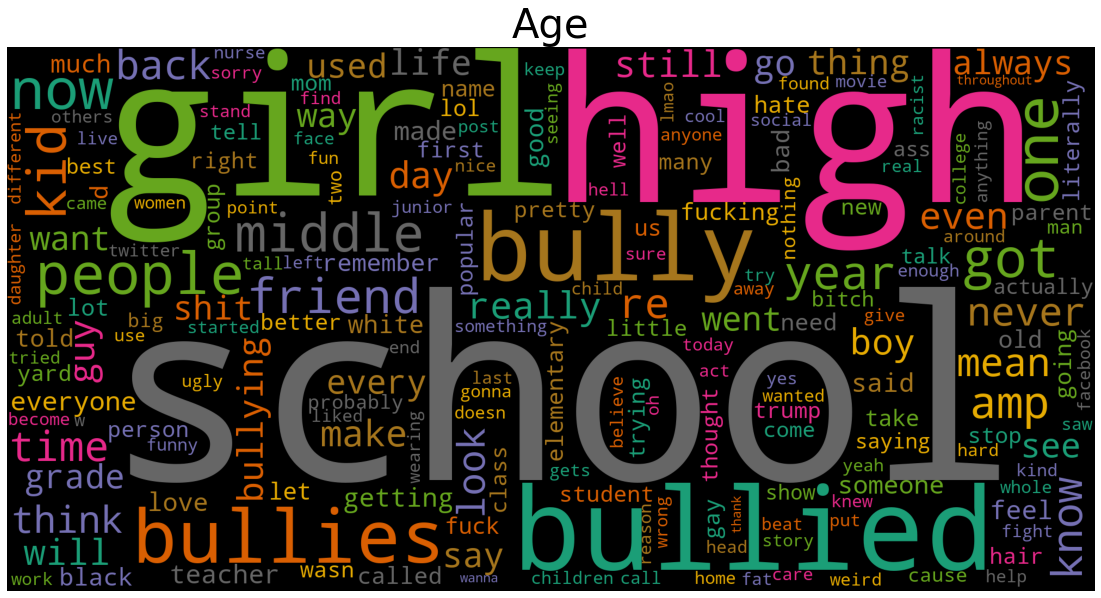

In [13]:
plt.figure(figsize=(20,10)) #Setting figure size to better width

subset_age = df_visual[df_visual['cyberbullying_type']=='age']
text_age = subset_age.tweet_text.values
cloud1=WordCloud(background_color='black',colormap="Dark2",collocations=False,width=2000,height=1000).generate(" ".join(text_age))

plt.axis('off')
plt.title("Age",fontsize=40)
plt.imshow(cloud1)

In [14]:
# Get the unigrams, single word that appear most 
unigrams_age = get_highest_gram(text_age,(1,1),10)

# Get the bigrams, two word that appear most
bigrams_age = get_highest_gram(text_age,(2,2),10)

age_1 = pd.DataFrame(unigrams_age, columns = ['Text' , 'count'])
age_1.groupby('Text').sum()['count'].sort_values(ascending=True).iplot(kind='bar', yTitle='Count', linecolor='black',color='black', title='Top 10 Unigrams',orientation='h')

age_2 = pd.DataFrame(bigrams_age, columns = ['Text' , 'count'])
age_2.groupby('Text').sum()['count'].sort_values(ascending=True).iplot(kind='bar', yTitle='Count', linecolor='black',color='black', title='Top 10 Bigrams',orientation='h')

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'let', 'mustn', 're', 'shan', 'shouldn', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.



# Data Preprocessing For Train In Deep Learning model
Note that the Data Frame `df_visual` is preprocessed (using different method) and are meant to use in word cloud data exploration only. Now I will switch back to main Data Frame `df` to do different preprocessing that will be used to fit into Deep Learning Model to train for the cyberbullying classification problems.

In [15]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was crapilicious! #mkr",not_cyberbullying
1,@gcarothers eek. i can't stand split keyboards. doesn't work well with MMOs.,not_cyberbullying
2,"@GlennF @Spacekatgal it is rather funny how all of us are so completely different, yet complement each other's skill sets so well.",not_cyberbullying
3,@jukes303 The old oil cliche again. The US pays for every drop of oil they get from the ME on the open market just like every other country.,not_cyberbullying
4,Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc,not_cyberbullying


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47693 entries, 0 to 47692
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47693 non-null  object
 1   cyberbullying_type  47693 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [17]:
# Rename columns into shorter words for easier references
df = df.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'bully_type'})

In [18]:
# df.duplicated function will take the row that have excalty same value across all columns as true
df.duplicated().sum()

46

In [19]:
# This line will drop the duplicated 46 rows
df = df[~df.duplicated()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47647 entries, 0 to 47692
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        47647 non-null  object
 1   bully_type  47647 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB



After dropping the 46 duplicated rows, the total rows had turn from `47693` to `47647`

In [20]:
# Now we want to check if the data class is balance
df['bully_type'].value_counts()

religion               7997
age                    7990
ethnicity              7959
gender                 7945
not_cyberbullying      7935
other_cyberbullying    7821
Name: bully_type, dtype: int64

The classes seem balanced

## Apply Deep Cleaning - Tweet Text
### In this deep cleaning, we going to apply:
* Strip emoji
* Strip all entities
* Decontract

*This Deep Cleaning is more comprehensive than previous one, because previous was meant for data exploration, while the complex one are necessary for our LSTM model to learn more efficient and effectively.

In [21]:
#Import all the library for deep cleansing
import re, string
import emoji
import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [22]:
#!pip install nltk
#!pip install emoji

In [23]:
##CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS

# Remove all emojis from text, since it is a twitter it might include some amount of emojis
def strip_emoji(text):
    return re.sub(emoji.get_emoji_regexp(), r"", text) #remove emoji

#Remove punctuations, links, stopwords, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
    text =' '.join(word for word in text.split() if len(word) < 14) # remove words longer than 14 characters
    return text

#remove contractions
def decontract(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the "#" symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as "&" and "$" present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

#Remove multiple sequential spaces
def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

#Stemming
def stemmer(text):
    tokenized = nltk.word_tokenize(text)
    ps = PorterStemmer()
    return ' '.join([ps.stem(words) for words in tokenized])

#Lemmatization 
#NOTE:Stemming seems to work better for this dataset
def lemmatize(text):
    tokenized = nltk.word_tokenize(text)
    lm = WordNetLemmatizer()
    return ' '.join([lm.lemmatize(words) for words in tokenized])

#Then we apply all the defined functions in the following order
def deep_clean(text):
    text = strip_emoji(text)
    text = decontract(text)
    text = strip_all_entities(text)
    text = clean_hashtags(text)
    text = filter_chars(text)
    text = remove_mult_spaces(text)
    text = stemmer(text)
    return text

In [24]:
new_texts = []
for each_text in df['text']:
    new_texts.append(deep_clean(each_text))

C:\Users\Admin\AppData\Local\Temp\ipykernel_5200\3236355396.py:5: DeprecationWarning:

'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'



Now we will add `df` Data Frame with a new columns called `new_text`, using deep cleaned text

In [25]:
df['clean_text'] = new_texts

In [26]:
df.head()

,text,bully_type,clean_text
0,"In other words #katandandre, your food was crapilicious! #mkr",not_cyberbullying,word katandandr food crapilici mkr
1,@gcarothers eek. i can't stand split keyboards. doesn't work well with MMOs.,not_cyberbullying,eek stand split keyboard work well mmo
2,"@GlennF @Spacekatgal it is rather funny how all of us are so completely different, yet complement each other's skill sets so well.",not_cyberbullying,rather funni us complet differ yet complement skill set well
3,@jukes303 The old oil cliche again. The US pays for every drop of oil they get from the ME on the open market just like every other country.,not_cyberbullying,old oil clich us pay everi drop oil get open market like everi countri
4,Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc,not_cyberbullying,aussietv white mkr theblock today sunris studio10 neighbour wonderlandten etc


In [27]:
df.tail()

,text,bully_type,clean_text
47688,"Black ppl aren't expected to do anything, depended on for anything. Yet free to participate, work, enjoy the freedom of humans all across this globe. If you waste your energy on the past you will be wasting it for building the future.",ethnicity,black ppl expect anyth depend anyth yet free particip work enjoy freedom human across globe wast energi past wast build futur
47689,Turner did not withhold his disappointment. Turner called the court an “abominable conclave of negro hating demons” (with one exception) who “issued another decree that colored men and women must be driven into Jim Crow cars whenever it suits the whim of any white community.”,ethnicity,turner withhold turner call court abomin conclav negro hate demon one except issu anoth decre color men women must driven jim crow car whenev suit whim white commun
47690,I swear to God. This dumb nigger bitch. I have got to bleach my hair reeeeeal fuckin' soon. D:&lt; FUCK.,ethnicity,swear god dumb nigger bitch got bleach hair reeeeeal fuckin soon dlt fuck
47691,"Yea fuck you RT @therealexel: IF YOURE A NIGGER FUCKING UNFOLLOW ME, FUCKING DUMB NIGGERS.",ethnicity,yea fuck rt your nigger fuck unfollow fuck dumb nigger
47692,Bro. U gotta chill RT @CHILLShrammy: Dog FUCK KP that dumb nigger bitch lmao,ethnicity,bro u got ta chill rt dog fuck kp dumb nigger bitch lmao


In [28]:
# Ultilize string interpolate to print information more clearly with label
print(f'Shape: {df.shape}')
sum_duplicate = df["clean_text"].duplicated().sum()
print(f'Duplicated Sum: {sum_duplicate}')

Shape: (47647, 3)
Duplicated Sum: 3061


In [29]:
df.drop_duplicates("clean_text", inplace=True) # Apply Inplace = True to actually apply into the df

In [30]:
df.shape

(44586, 3)

In [31]:
# Recheck Class Balance
df['bully_type'].value_counts()

religion               7945
age                    7881
ethnicity              7743
not_cyberbullying      7635
gender                 7604
other_cyberbullying    5778
Name: bully_type, dtype: int64

As we can see, most of the dropped duplicated instance are from `other_cyberbullying` class, which make the class drop to `5,778` compare to other `7,xxx`

In [32]:
#df = df[df["bully_type"]!="other_cyberbullying"]
#classes = ["religion","age","ethnicity","gender","not bullying"]

### Tweet Text Length Analysis
Now we will create a new column called `text_length` in `df`, calculating the word length and input in it, so it is more easy to view and do plotting

In [33]:
text_length = []
for each_text in df['clean_text']:
    each_length = len(each_text.split())
    text_length.append(each_length)

In [34]:
# Apply the text length list array into data frame
df['text_length'] = text_length
df.head()

,text,bully_type,clean_text,text_length
0,"In other words #katandandre, your food was crapilicious! #mkr",not_cyberbullying,word katandandr food crapilici mkr,5
1,@gcarothers eek. i can't stand split keyboards. doesn't work well with MMOs.,not_cyberbullying,eek stand split keyboard work well mmo,7
2,"@GlennF @Spacekatgal it is rather funny how all of us are so completely different, yet complement each other's skill sets so well.",not_cyberbullying,rather funni us complet differ yet complement skill set well,10
3,@jukes303 The old oil cliche again. The US pays for every drop of oil they get from the ME on the open market just like every other country.,not_cyberbullying,old oil clich us pay everi drop oil get open market like everi countri,14
4,Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc,not_cyberbullying,aussietv white mkr theblock today sunris studio10 neighbour wonderlandten etc,10


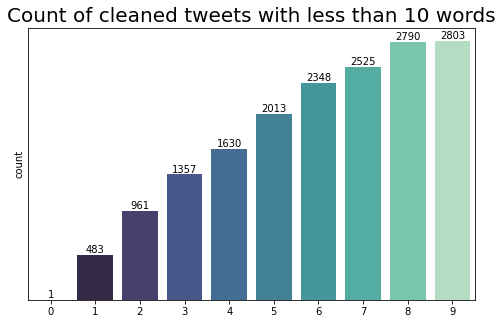

In [35]:
plt.figure(figsize=(8,5))
ax = sns.countplot(x='text_length', data=df[df['text_length']<10], palette='mako')
plt.title('Count of cleaned tweets with less than 10 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

If a tweets are too shorted, Deep Learning Model will not able to make sense of it, it will become the problematic outlier that will ruin the accuracy of the model while training and validationg.

We will remove tweets that are too short (less or equal than `3 words`).

In [36]:
df = df[df['text_length'] > 3]

We also need to check about tweet text that are too long, if a tweet had more than `100++` words that it is considered outlier that can affect the model too.

In [37]:
pd.set_option('display.max_colwidth', 100)
df.sort_values(by=['text_length'], ascending=False)

,text,bully_type,clean_text,text_length
29206,is feminazi an actual word with a denot…\r\n@Nasharchy my job means protecting people. even the ...,other_cyberbullying,feminazi actual word denot job mean protect peopl even peopl agre withlik bare cook anyth entr m...,385
24517,@NICKIMINAJ: #WutKinda\r\nAt this rate the MKR final will be in December #MKR\r\n@Ethelmonster @...,other_cyberbullying,wutkinda rate mkr final decemb mkr haha true u never notic tweet bulli thing realli bug peopl mi...,352
30753,I don't retreat.\r\nyessssssss http://t.co/Td90k9Ik2r\r\nUh. Why do they not make these for grow...,other_cyberbullying,retreat yessssssss uh make grownup boruto look lit badass like filthi cunt awkward good case stu...,238
44036,You so black and white trying to live like a nigger... Pahahahaha... Common is dumb as fuck!\r\n...,ethnicity,black white tri live like nigger pahahahaha common dumb fuck short huntsman dumb ass ya fuck gay...,187
45166,"@hermdiggz: “@tayyoung_: FUCK OBAMA, dumb ass nigger” this bitch &lt;~~This Whore SMH\r\nI don’t...",ethnicity,fuck obama dumb ass nigger bitch ltthi whore smh dont think either dont put anyth past nigga com...,162
...,...,...,...,...
1613,I don't even remember any of these people #mkr,not_cyberbullying,even rememb peopl mkr,4
25414,Do you run -CURRENT or just the latest -RELEASE?,other_cyberbullying,run current latest releas,4
38585,I bet she was an arrogant bully at school..,age,bet arrog bulli school,4
1616,You don't suck Sheri and Emilie #DontLetTheBehaviourOfOthersGetYouDown #mkr,not_cyberbullying,suck sheri emili mkr,4


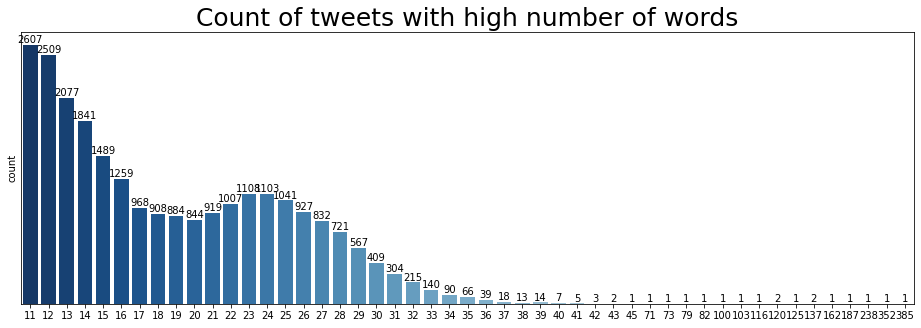

In [38]:
# Now we want to use countplot to plot the length size of the tweet text, length in between 10 to 1000

plt.figure(figsize=(16,5))
ax = sns.countplot(x='text_length', data=df[(df['text_length']<=1000) & (df['text_length']>10)], palette='Blues_r')
plt.title('Count of tweets with high number of words', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

As we can see from the graph, most tweets text length are from 11 to 30 which are good, decided to drop text length logner than 100.

In [39]:
df = df[df['text_length'] < 100]

In [40]:
max_length = np.max(df['text_length'])
max_length

82

In [41]:
df.sort_values(by=["text_length"], ascending=False)

,text,bully_type,clean_text,text_length
25412,@Sweetie_Niesha: So Im getting bullied via twitter by @TheVicSmith\r\n@hridaybala I don't read b...,other_cyberbullying,im get bulli via twitter read breitbart rt lt3 scene captain america grenad would lt3 grey lion ...,82
4847,@andrea_gcav: @viviaanajim recuerdas como nosotras también eramos victimas del bullying/ jajaja ...,not_cyberbullying,recuerda como nosotra tambin eramo victima del bulli jajaja callat marc cuando nosotra bulleabam...,79
44295,"@JasmineLovvee If He Dont Want You Well Fuck Him , He Aint Worth Your Tears , Never Sweat A Dumb...",ethnicity,dont want well fuck aint worth tear never sweat dumb nigger sound like 85 mad dumb go fuck black...,73
25940,"If cats looked like frogs we'd realize what nasty, cruel little\r\nhttp://t.co/ZxbZV39jru: Cat A...",other_cyberbullying,cat look like frog would realiz nasti cruel littl cat attack pork rib attack coon main pork wrot...,71
45931,"Get off ur ego trip, take off ur rose colored glasses &amp; get real! U’ll be lucky if ur in off...",ethnicity,get ur ego trip take ur rose color glass amp get real ull lucki ur offic next year ppl r fed ur ...,45
...,...,...,...,...
3044,#MKR really stretching it out this year,not_cyberbullying,mkr realli stretch year,4
3046,Finna make a change to my circle,not_cyberbullying,finna make chang circl,4
28710,@sjtoplin if I was a bully I would have used your name.,other_cyberbullying,bulli would use name,4
28708,"oh my god, i'm so fuckin ugly ð",other_cyberbullying,oh god fuckin ugli,4


# Cyberbullying Type Encoding

In [42]:
cyberbully_type_dictionary = {
    'religion': 0,
    'age': 1,
    'ethnicity': 2,
    'gender': 3,
    'other_cyberbullying': 4,
    'not_cyberbullying': 5
}

In [44]:
df['bully_type'] = df['bully_type'].replace(cyberbully_type_dictionary)
df.head()

,text,bully_type,clean_text,text_length
0,"In other words #katandandre, your food was crapilicious! #mkr",5,word katandandr food crapilici mkr,5
1,@gcarothers eek. i can't stand split keyboards. doesn't work well with MMOs.,5,eek stand split keyboard work well mmo,7
2,"@GlennF @Spacekatgal it is rather funny how all of us are so completely different, yet complemen...",5,rather funni us complet differ yet complement skill set well,10
3,@jukes303 The old oil cliche again. The US pays for every drop of oil they get from the ME on th...,5,old oil clich us pay everi drop oil get open market like everi countri,14
4,Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours ...,5,aussietv white mkr theblock today sunris studio10 neighbour wonderlandten etc,10


# Data preprocessing for LSTM

In [54]:
from collections import Counter
from gensim.models import Word2Vec

def Tokenize(column, seq_len):
    ##Create vocabulary of words from column
    corpus = [word for text in column for word in text.split()]
    count_words = Counter(corpus)
    sorted_words = count_words.most_common()
    vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

    ##Tokenize the columns text using the vocabulary
    text_int = []
    for text in column:
        r = [vocab_to_int[word] for word in text.split()]
        text_int.append(r)
    ##Add padding to tokens
    features = np.zeros((len(text_int), seq_len), dtype = int)
    for i, review in enumerate(text_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)

    return sorted_words, features

In [55]:
vocabulary, tokenized_column = Tokenize(df["clean_text"], max_length) #Note that we get the max length in previous code

In [57]:
df["clean_text"].iloc[10]

'rebecca black drop school due bulli'

In [58]:
tokenized_column[10]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 2378,
         22,  631,    2,  715,    1])

Moreover we can also check the TOP 20 most common words by extracting them from the vocabulary python dictionary we created with the tokenizer.

In [59]:
keys = []
values = []
for key, value in vocabulary[:20]:
    keys.append(key)
    values.append(value)

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



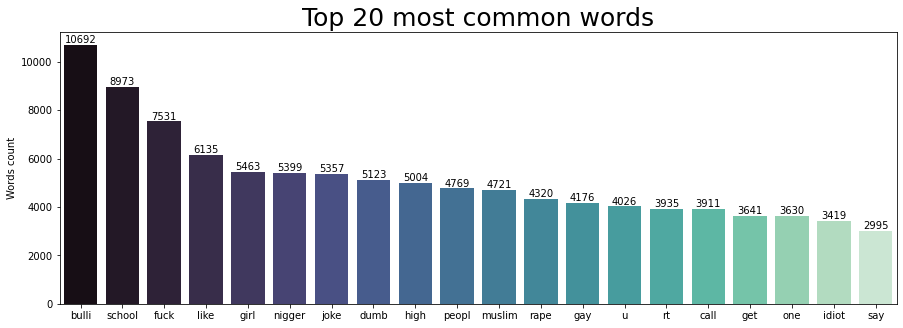

In [60]:
plt.figure(figsize=(15, 5))
ax = sns.barplot(keys, values, palette='mako')
plt.title('Top 20 most common words', size=25)
ax.bar_label(ax.containers[0])
plt.ylabel("Words count")
plt.show()

In [61]:
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [62]:
EMBEDDING_DIM = 200

In [63]:
word2vec_model = Word2Vec(Word2vec_train_data, vector_size=EMBEDDING_DIM)

In [64]:
print(f"Vocabulary size: {len(vocabulary) + 1}")

Vocabulary size: 34831


In [65]:
VOCAB_SIZE = len(vocabulary) + 1 #+1 for the padding

In [66]:
#define empty embedding matrix
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
    
#fill the embedding matrix with the pre trained values from word2vec
#    corresponding to word (string), token (number associated to the word)
for word, token in vocabulary:
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (34831, 200)


## Train - Test - Validation Split

We going to take TOKENIZED `clean_text` columns called `tokenized_column` for X datasets and `bully_type` for y datasets only, noted that the X is capital as purpose for naming convetion while y is small letter

In [68]:
X = tokenized_column
y = df['bully_type'].values

In [71]:
from sklearn.model_selection import train_test_split

seed_value = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [78]:
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')

X_train: (30074, 82)
y_train: (30074,)
X_test: (8355, 82)
y_test: (8355,)


After splitting into train and test set, we are going to split another small set from `train set` as `validation set`

In [76]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=seed_value)

In [79]:
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')
print(f'y_train: {X_valid.shape}')
print(f'y_test: {y_valid.shape}')

X_train: (30074, 82)
y_train: (30074,)
X_test: (8355, 82)
y_test: (8355,)
y_train: (3342, 82)
y_test: (3342,)


Now we can check the balance of the target classes

In [82]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5682],
       [   1, 5635],
       [   2, 5549],
       [   3, 5261],
       [   4, 3362],
       [   5, 4585]], dtype=int64)

## Building BLSTM Model

In [88]:
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, LSTM

In [90]:
model = Sequential()

#Non-trainable embeddidng layer
model.add(Embedding(max_features, output_dim=embed_size, input_length=maxlen, trainable=False))

model.add(Bidirectional(LSTM(10, return_sequences=True), input_shape=(5, 10)))
model.add(Bidirectional(LSTM(10)))
model.add(Dense(6, activation='softmax'))

In [92]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])